In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
from itertools import chain

import nltk
import numpy as np
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
import json

In [5]:
from fuzzywuzzy import process

In [6]:
def search_ontology_for_acts(word, ontology, req=True, thresh=60):
    """
    return True if word or similar word in ontology
    else return False;
    
    // ontology = {'request':requests_list, 'inform':informs_list}
    
    """
    
    name = 'request'
    if not req:
        name = 'inform'

    if word in ontology[name]:
        return True
    else:
        matches = process.extractOne(word, ontology[name])
        if matches[1]>thresh:
            return True
        else:
            return False

In [7]:
def search_ontology_for_slots(word, slot_ontology, thresh=60):
    """
    
    """
    matches = {}
    
    for key, arr in slot_ontology.items():
        val = process.extractOne(word, arr)[1]
        matches[key] = 1 if val>thresh else 0
    
    return matches

In [8]:
### delexicalisation ####

class FeatureGen:
    def __init__(self, ontology_path):
        with open(ontology_path, 'r') as fs:
            ont = json.load(fs)
            
        requests = ont['requestable'].values()
        requests = [v for m in requests for v in m]
        informs = ont['informable']['area'] + ont['informable']['food'] + ont['informable']['pricerange']
        self.ont_acts = {'request':requests, 'inform':informs}
        
        self.ont_slots = {
        'area': ont['informable']['area'] + ont['requestable']['area'],
        'food': ont['informable']['food'] + ont['requestable']['food'],
        'pricerange': ont['informable']['pricerange'] + ont['requestable']['pricerange'],
        'name': ont['requestable']['name'],
        'phone': ont['requestable']['phone'],
        'postcode': ont['requestable']['postcode'],
        'addr': ont['requestable']['addr']
        }


    def word2features(self, sent, i, for_acts = True):

        word = sent[i]
        features = {
            'bias': 1.0,
            'word[-3:]': word[-3:],
            'word[-2:]': word[-2:],
            'word[:3]': word[:3],
            'word.isupper()': word.isupper(),
            'word.istitle()': word.istitle(),
            'word.isdigit()': word.isdigit(),   
        }

        if for_acts:
            features.update({
            'word.request': search_ontology_for_acts(word.lower(), ontology=self.ont_acts, req=True),
            'word.inform': search_ontology_for_acts(word.lower(), ontology=self.ont_acts, req=False)})
        else:
            matches = search_ontology_for_slots(word, self.ont_slots)
            features.update(matches)

        if i > 0:
            word1 = sent[i-1]
            features.update({
                '-1:word.lower()': word1.lower(),
                '-1:word.istitle()': word1.istitle(),
                '-1:word.isupper()': word1.isupper(),
                '-1:word[-3:]': word1[-3:],
            })
        else:
            features['BOS'] = True # begin of sentence

        if i < len(sent)-1:
            word1 = sent[i+1][0]
            features.update({
                '+1:word.istitle()': word1.istitle(),
                '+1:word.isupper()': word1.isupper(),
                '+1:word[-3:]': word1[-3:],
            })
            
        else:
            features['EOS'] = True # end of sentence

        return features


    def sent2features(self, sent, for_acts = True):
        """
        input looks like:
            sent = ['okay', 'and', 'can', 'i', 'get', 'their', 'phone']
            acts = ['O', 'O', 'O', 'O', 'O', 'O', 'B-request']
            slots = ['O', 'O', 'O', 'O', 'O', 'O', 'B-phone']

        here for_acts=True means that you would like to make features to predict acts;
        if you want predict slots you should pass for_acts=False;

        """
        if isinstance(sent, str):
            sent = sent.split()
        return [self.word2features(sent, i, for_acts=for_acts) for i in range(len(sent))]

    def batch2features(self, x_words, DataGen, for_acts = True):

        feats = []
        for x_ in x_words:
            sent = DataGen.decode_sentence(x_)
            feats.append(self.sent2features(sent, for_acts = for_acts))
        return feats

In [9]:
from data_generator import NLUDataGenerator

batch_size = 3800
TimeMajor = False

DataGenDev = NLUDataGenerator('../data/dev/usr_df_final.csv',
                           '../data/ontology_new.json',
                           '../data/slots', None,
                           batch_size = int(batch_size*0.6), time_major=TimeMajor)

DataGen = NLUDataGenerator('../data/train/usr_df_final.csv',
                           '../data/ontology_new.json',
                           '../data/slots', DataGenDev.vocab,
                           batch_size = batch_size, time_major=TimeMajor)

len(diff):  175
tmp len:  175
before:  474
fin:  649


In [44]:
x, m1, m2, _lens = next(DataGen)
N = 5

for x_, m1_, m2_ in zip(x[:N], m1[:N], m2[:N]):
    print(DataGen.decode_sentence(x_))
    print(DataGen.decode_slots(m1_))
    print(DataGen.decode_acts(m2_))

['something', 'serving', 'russian', 'food']
['O', 'O', 'B-food', 'O']
['O', 'O', 'B-inform', 'O']
['um', 'scandinavian']
['O', 'B-food']
['O', 'B-inform']
['i', 'want', 'to', 'find', 'a', 'restaurant', 'in', 'the', 'center', 'that', 'serves', 'welsh', 'food']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-area', 'O', 'O', 'B-food', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-inform', 'O', 'O', 'B-inform', 'O']
['im', 'looking', 'for', 'a', 'dontcare', 'restaurant', 'that', 'serves', 'gastropub']
['O', 'O', 'O', 'O', 'B-pricerange', 'O', 'O', 'O', 'B-food']
['O', 'O', 'O', 'O', 'B-inform', 'O', 'O', 'O', 'B-inform']
['moderate', 'priced', 'hungarian', 'food']
['B-pricerange', 'O', 'B-food', 'O']
['B-inform', 'O', 'B-inform', 'O']


## Slots

In [10]:
fGen = FeatureGen("../data/ontology_new.json")

In [59]:
%%time
x, m1, m2, _lens = next(DataGen)
N = 3000
X_train_slots = fGen.batch2features(x[:N], for_acts=False, DataGen=DataGen)
y_train_slots = [DataGen.decode_slots(m) for m in m1[:N]]

CPU times: user 4min 44s, sys: 3 s, total: 4min 47s
Wall time: 4min 51s


In [57]:
%%time
x, m1, m2, _lens = next(DataGenDev)
N = 1000
X_test_slots = fGen.batch2features(x[:N], for_acts=False, DataGen=DataGenDev)
y_test_slots = [DataGen.decode_slots(m) for m in m1[:N]]

CPU times: user 1min 34s, sys: 1.26 s, total: 1min 36s
Wall time: 1min 39s


In [60]:
crf_slots = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.003,
    c2=0.04,
    max_iterations=100,
    all_possible_transitions=True
)
crf_slots.fit(X_train_slots, y_train_slots)

CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=0.003, c2=0.04,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

In [61]:
labels_slots = list(crf_slots.classes_)
labels_slots.remove('O')
labels_slots

['B-pricerange',
 'B-area',
 'B-food',
 'B-addr',
 'B-phone',
 'I-pricerange',
 'B-reqalts',
 'I-phone',
 'B-bye',
 'B-postcode',
 'I-postcode',
 'I-area',
 'B-negate',
 'B-affirm',
 'B-name',
 'I-name',
 'B-hello',
 'I-food']

In [62]:
test_sent = "I'm searching for a cheap restaurant in the center of town"
test_sent_feats = fGen.sent2features(test_sent, for_acts=False)
p_test = crf_slots.predict([test_sent_feats])
p_test

[['O', 'O', 'O', 'O', 'B-pricerange', 'O', 'O', 'O', 'B-area', 'O', 'O']]

In [76]:
test_sent = "I'm searching for a cheap restaurant in the center of town"
test_sent_feats = fGen.sent2features(test_sent, for_acts=False)
p_test = crf.predict([test_sent_feats])
p_test

[['O', 'O', 'O', 'O', 'B-inform', 'O', 'O', 'O', 'B-inform', 'O', 'O']]

In [78]:
test_sent = "I don't care about price range. What about rssan food restaurant?"
test_sent_feats = fGen.sent2features(test_sent, for_acts=False)
p_test = crf_slots.predict([test_sent_feats])
p_test

[['O',
  'O',
  'O',
  'O',
  'B-pricerange',
  'I-pricerange',
  'O',
  'O',
  'B-food',
  'O',
  'O']]

In [81]:
test_sent = "I don't care about price range. What about itlan food restaurant?"
test_sent_feats = fGen.sent2features(test_sent, for_acts=False)
p_test = crf.predict([test_sent_feats])
p_test

[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-inform', 'O', 'O']]

In [64]:
y_pred = crf_slots.predict(X_test_slots)
metrics.flat_f1_score(y_test_slots, y_pred,
                      average='weighted', labels=labels_slots)

0.86163765622968291

In [65]:
sorted_labels = sorted(
    labels_slots,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test_slots, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

      B-addr      0.991     1.000     0.996       112
    B-affirm      1.000     0.448     0.619        29
      B-area      0.978     0.967     0.972       273
      I-area      0.000     0.000     0.000        11
       B-bye      0.000     0.000     0.000        16
      B-food      0.903     0.942     0.922       327
      I-food      0.889     1.000     0.941        16
     B-hello      0.000     0.000     0.000       103
      B-name      0.800     0.667     0.727         6
      I-name      0.857     0.667     0.750         9
    B-negate      0.722     0.975     0.830        40
     B-phone      0.992     0.992     0.992       118
     I-phone      0.920     1.000     0.958        23
  B-postcode      1.000     1.000     1.000        35
  I-postcode      1.000     1.000     1.000        27
B-pricerange      0.951     0.989     0.969       273
I-pricerange      0.815     1.000     0.898        22
   B-reqalts      0.852    

## Acts

In [45]:
%%time
x, m1, m2, _lens = next(DataGen)
N = 3000
X_train_acts = fGen.batch2features(x[:N],for_acts=True, DataGen=DataGen)
y_train_acts = [DataGen.decode_acts(m) for m in m2[:N]]

CPU times: user 4min 9s, sys: 2.43 s, total: 4min 12s
Wall time: 4min 14s


In [46]:
x, m1, m2, _lens = next(DataGenDev)
N = 1000
X_test_acts = fGen.batch2features(x[:N],for_acts=True, DataGen=DataGenDev)
y_test_acts = [DataGenDev.decode_acts(m) for m in m2[:N]]

In [30]:
import pandas as pd
data = pd.read_csv("../data/dev/usr_df_final.csv")
# data[((data.slot1 == 'phone')|(data.slot2 == 'phone')|(data.slot3 == 'phone'))]
#      ((data.act1 != 'request')|(data.act2 != 'request')&(data.act3 != 'request'))]

data[(data.slot3 == 'phone')&(data.act3 != 'request')]

Empty DataFrame
Columns: [nl, act1, act2, act3, slot1, slot2, slot3]
Index: []

In [47]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.003,
    c2=0.04,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train_acts, y_train_acts)

CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=0.003, c2=0.04,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

In [48]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B-inform',
 'B-confirm',
 'B-request',
 'B-affirm',
 'I-request',
 'B-bye',
 'B-reqalts',
 'I-inform',
 'B-dontcare',
 'B-negate',
 'B-hello',
 'B-doncare',
 'I-doncare',
 'I-negate',
 'I-confirm']

In [49]:
y_pred = crf.predict(X_test_acts)
metrics.flat_f1_score(y_test_acts, y_pred,
                      average='weighted', labels=labels)

0.88028776118372054

In [50]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test_acts, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

   B-affirm      1.000     0.275     0.431        51
      B-bye      0.895     1.000     0.945       111
  B-confirm      0.500     0.185     0.270        27
  I-confirm      0.000     0.000     0.000         1
  B-doncare      0.000     0.000     0.000         0
  I-doncare      0.000     0.000     0.000         0
 B-dontcare      0.000     0.000     0.000         0
    B-hello      1.000     0.273     0.429        11
   B-inform      0.919     0.972     0.945       727
   I-inform      0.636     0.500     0.560        14
   B-negate      0.596     0.519     0.554        54
   I-negate      0.000     0.000     0.000         1
  B-reqalts      0.897     0.493     0.636        71
  B-request      0.923     0.982     0.952       340
  I-request      0.913     1.000     0.954        94

avg / total      0.897     0.891     0.880      1502



# Top transitions

In [51]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
B-bye  -> B-bye   6.765789
B-hello -> B-hello 6.330480
B-affirm -> B-affirm 6.115494
B-reqalts -> B-reqalts 6.019926
B-inform -> I-inform 5.917907
B-negate -> B-negate 5.238124
I-inform -> I-inform 5.110579
B-confirm -> I-confirm 4.460859
B-negate -> I-negate 4.354201
I-negate -> I-negate 4.220071
B-doncare -> I-doncare 4.182880
B-request -> I-request 3.767073
O      -> O       3.538894
I-request -> I-request 3.471571
B-confirm -> B-confirm 3.036377
O      -> B-inform 1.775895
O      -> B-request 1.648297
B-inform -> O       1.456951
B-request -> O       1.262289
O      -> B-confirm 1.170556

Top unlikely transitions:
O      -> I-inform -2.029583
B-affirm -> B-inform -2.236591
B-confirm -> B-request -2.427503
B-confirm -> B-inform -2.481716
O      -> B-affirm -2.560384
I-negate -> B-reqalts -2.799130
O      -> B-hello -2.799517
O      -> I-negate -2.972953
B-bye  -> O       -2.992703
B-negate -> B-reqalts -3.318456
O      -> B-bye   -3.433141
B-affirm -> O      

# State features

In [52]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
7.358333 O        word[:3]:sig
6.138453 B-negate -1:word.lower():no
6.138453 B-negate -1:word[-3:]:no
5.887595 B-confirm -1:word.lower():that
5.613555 B-request word[:3]:add
5.485397 B-dontcare +1:word[-3:]:w
5.454254 O        word[-3:]:sea
4.958921 B-inform word[:3]:kos
4.890298 B-request word[-3:]:rea
4.815315 O        word[-3:]:ral
4.779829 B-confirm -1:word.lower():it
4.779829 B-confirm -1:word[-3:]:it
4.704908 B-inform word[-3:]:que
4.651113 B-inform word[-3:]:pes
4.575608 O        word[:3]:end
4.442076 B-inform word[:3]:wes
4.436116 O        word[:3]:fis
4.343504 B-confirm word[:3]:sco
4.315326 O        word[:3]:por
4.217681 O        word[:3]:nym
4.205639 B-inform word[:3]:afr
4.197692 O        word[:3]:chi
4.171978 O        word[:3]:asi
4.157494 I-request word[:3]:num
4.156096 B-inform word[-3:]:ean
4.153492 O        word[:3]:mat
4.064458 B-dontcare -1:word.lower():what
4.039639 B-request word[-3:]:ame
4.039639 B-request word[:3]:nam
4.019161 B-dontcare -1:word[-3:

In [82]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf_slots.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf_slots.state_features_).most_common()[-30:])

Top positive:
8.664850 O        word[:3]:sig
6.419773 B-food   word[-3:]:que
5.258038 B-pricerange word[:3]:exp
5.022893 B-food   word[-2:]:al
4.977898 O        word[-3:]:ral
4.951124 O        word[:3]:fis
4.950870 B-food   word[:3]:kos
4.839313 B-food   word[:3]:tus
4.783736 B-food   word[-3:]:pes
4.748209 B-addr   word[:3]:add
4.669999 B-area   word[-3:]:rea
4.630712 B-food   word[:3]:bis
4.588483 B-food   word[-2:]:an
4.566368 B-food   word[-3:]:ese
4.359725 B-food   word[:3]:afr
4.264764 B-food   word[-3:]:ish
4.219020 O        bias
4.153846 B-area   word[-2:]:th
4.122259 B-area   word[:3]:wes
4.029510 B-food   word[-2:]:se
4.009262 B-pricerange word[-3:]:ate
4.008143 O        word[-3:]:sea
4.007657 B-pricerange word[-2:]:te
3.931691 B-food   word[-3:]:ean
3.909693 O        word[:3]:end
3.901071 B-food   word[:3]:hun
3.862830 O        word[:3]:spe
3.830566 O        word[:3]:asi
3.824505 B-food   word[:3]:cre
3.818894 O        word[:3]:mat

Top negative:
-1.633308 O        word[-3:]

# Params search

In [14]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train_acts, y_train_acts)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside

/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside

/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside

/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside

/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside

/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside

/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside

/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside

/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fogside/virtualenvs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fogside

CPU times: user 27.7 s, sys: 2.24 s, total: 30 s
Wall time: 6min 40s


In [15]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.003020247418494537, 'c2': 0.042603304765036605}
best CV score: 0.941982929801208
model size: 0.19M


In [16]:
crf = rs.best_estimator_

In [28]:
y_pred = crf.predict(X_test_acts)
metrics.flat_f1_score(y_test_acts, y_pred,
                      average='weighted', labels=labels)

0.89983953377455739

In [29]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test_acts, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

   B-affirm      0.678     0.336     0.449       119
   I-affirm      0.000     0.000     0.000         0
      B-bye      0.939     0.963     0.951       240
  B-confirm      0.533     0.314     0.395        51
  I-confirm      1.000     1.000     1.000         1
    B-hello      1.000     0.200     0.333        30
   B-inform      0.932     0.978     0.955      1594
   I-inform      0.975     0.765     0.857        51
   B-negate      0.606     0.576     0.590       139
   I-negate      0.000     0.000     0.000         1
  B-reqalts      0.911     0.626     0.742       131
  B-request      0.971     0.954     0.963       808
  I-request      0.959     0.955     0.957       222

avg / total      0.916     0.897     0.900      3387



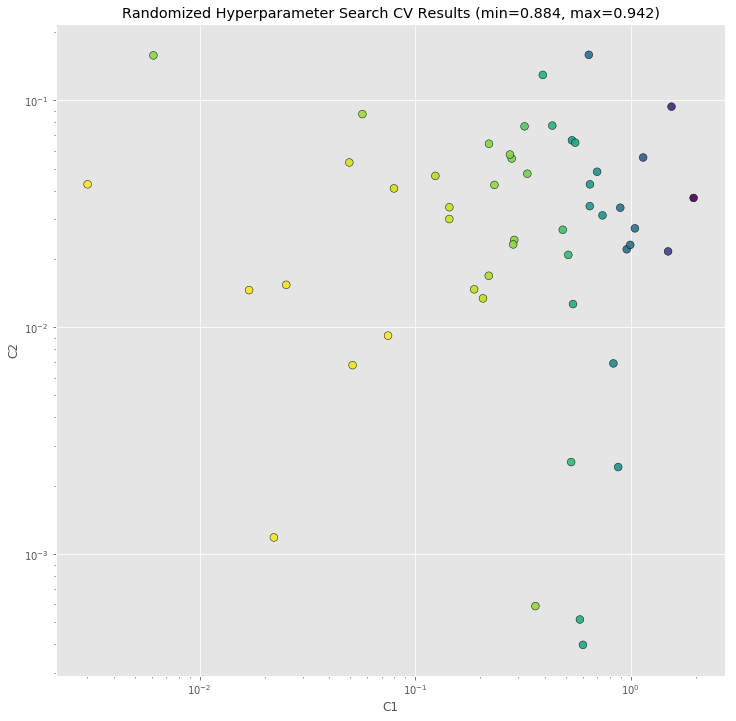

In [22]:
_x = [s.parameters['c1'] for s in rs.grid_scores_]
_y = [s.parameters['c2'] for s in rs.grid_scores_]
_c = [s.mean_validation_score for s in rs.grid_scores_]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])


# Model saving

In [1]:
import joblib as jb

In [83]:
jb.dump(crf, "./crf_actions.model")

['./crf_actions.model']

In [84]:
jb.dump(crf_slots, "./crf_slots.model")

['./crf_slots.model']

In [2]:
slots_m = jb.load("./crf_slots.model")

# Data editing

In [2]:
import pandas as pd
import numpy as np

In [106]:
data = pd.read_csv("../data/dev/usr_df_final.csv")
data.head()

nl      act1    act2 act3  \
0  i would like to find an $pricerange$ restauran...    inform  inform  NaN   
1                                    does not matter  dontcare     NaN  NaN   
2                        $food$ type of food is okay    inform     NaN  NaN   
3                                 what is the $addr$   request     NaN  NaN   
4                                what is the $phone$   request     NaN  NaN   

        slot1 slot2 slot3  
0  pricerange  area   NaN  
1         NaN   NaN   NaN  
2        food   NaN   NaN  
3        addr   NaN   NaN  
4       phone   NaN   NaN

In [91]:
data_w = data[data.nl.str.contains("care")]
data_w

nl           act1  \
15                   i dont care about the $pricerange$  dontcare_slot   
44                                          i dont care       dontcare   
93                     dont care is there anything else        reqalts   
94                                            dont care       dontcare   
128                                      uh i dont care       dontcare   
172                       dont care dont care dont care       dontcare   
214                                     umh i dont care       dontcare   
218               um i dont care about the $pricerange$  dontcare_slot   
461   im looking for a $food$ food restaurant and i ...         inform   
561                                      ah i dont care       dontcare   
694   let me get some $food$ food and i dont care ab...         inform   
775                                      oh i dont care       dontcare   
817                                       i do not care       dontcare   
833   i do not care about the $pricerange$ im just l...  dontcare_slot   
864                                      um do not care       dontcare   
865                                     i dont care bye       dontcare   
1030                 i dont care is there anything else        reqalts   
1347                        i dont care can i try again       dontcare   
1403  i dont care about the $pricerange$ what about ...       dontcare   
1410  i dont care about the $pricerange$ what is the...       dontcare   
1528                okay i dont care about $pricerange$  dontcare_slot   
1606         yes and i dont care about the $pricerange$  dontcare_slot   
1668  ah yes im looking for $food$ food and i dont c...         inform   
1720                     i dont care about $pricerange$  dontcare_slot   
1727                            i dont care what $area$  dontcare_slot   
1736  im looking for $food$ food i dont care about t...         inform   
1738                      i dont care what $pricerange$  dontcare_slot   

          act2    act3       slot1       slot2 slot3  
15         NaN     NaN  pricerange         NaN   NaN  
44         NaN     NaN         NaN         NaN   NaN  
93         NaN     NaN         NaN         NaN   NaN  
94         NaN     NaN         NaN         NaN   NaN  
128        NaN     NaN         NaN         NaN   NaN  
172        NaN     NaN         NaN         NaN   NaN  
214        NaN     NaN         NaN         NaN   NaN  
218        NaN     NaN  pricerange         NaN   NaN  
461   dontcare     NaN        food  pricerange   NaN  
561        NaN     NaN         NaN         NaN   NaN  
694   dontcare     NaN        food  pricerange   NaN  
775        NaN     NaN         NaN         NaN   NaN  
817        NaN     NaN         NaN         NaN   NaN  
833     inform  inform  pricerange        food  area  
864        NaN     NaN         NaN         NaN   NaN  
865        NaN     NaN         NaN         NaN   NaN  
1030       NaN     NaN         NaN         NaN   NaN  
1347       NaN     NaN         NaN         NaN   NaN  
1403    inform     NaN  pricerange        food   NaN  
1410   request     NaN  pricerange        addr   NaN  
1528       NaN     NaN  pricerange         NaN   NaN  
1606       NaN     NaN  pricerange         NaN   NaN  
1668  dontcare     NaN        food  pricerange   NaN  
1720       NaN     NaN  pricerange         NaN   NaN  
1727       NaN     NaN        area         NaN   NaN  
1736  dontcare     NaN        food  pricerange   NaN  
1738       NaN     NaN  pricerange         NaN   NaN

In [121]:
w = 'negate'
data[((data.act1 == w)|(data.act2 == w)|(data.act3 == w))]

nl    act1 act2 act3 slot1 slot2 slot3
30                      no  negate  NaN  NaN   NaN   NaN   NaN
109                    not  negate  NaN  NaN   NaN   NaN   NaN
159                  wrong  negate  NaN  NaN   NaN   NaN   NaN
364  no thank you good bye  negate  NaN  NaN   NaN   NaN   NaN
495                 tv_ no  negate  NaN  NaN   NaN   NaN   NaN
496           no dont care  negate  NaN  NaN   NaN   NaN   NaN
513           no thank you  negate  NaN  NaN   NaN   NaN   NaN
668      no something else  negate  NaN  NaN   NaN   NaN   NaN
695                  no ah  negate  NaN  NaN   NaN   NaN   NaN
722               wrong no  negate  NaN  NaN   NaN   NaN   NaN

In [120]:
w = 'negate'
data_w = data[~((pd.isnull(data.slot1))&(pd.isnull(data.slot2))&(pd.isnull(data.slot3)))
     & ((data.act1 == w)|(data.act2 == w)|(data.act3 == w))]
data_w

Empty DataFrame
Columns: [nl, act1, act2, act3, slot1, slot2, slot3]
Index: []

In [45]:
for i, row in data_w.iterrows():
    if 'american' in row.nl:
        data.ix[i,'nl'] = data.ix[i,'nl'].replace("american", "$food$")
        data.ix[i, 'slot1'] = "food"

In [119]:
for i, row in data_w.iterrows():
    data.ix[i, 'act1'] = "negate_slot"

In [107]:
w = 'dontcare'
data_w_sl = data[(~(pd.isnull(data.slot1))&(pd.isnull(data.slot2))&(pd.isnull(data.slot3)))
     & ((data.act1 == w)|(data.act2 == w)|(data.act3 == w))]
data_w_sl

Empty DataFrame
Columns: [nl, act1, act2, act3, slot1, slot2, slot3]
Index: []

In [122]:
data.to_csv("../data/dev/usr_df_final.csv", index=False)

In [124]:
from numpy.random import RandomState
lol = RandomState(3)

In [125]:
lol.choice([2,23,4])

4

In [131]:
from collections import defaultdict

In [139]:
lol = dict(lel='p', kek='lol')
lol

{'kek': 'lol', 'lel': 'p'}

In [145]:
list(reversed([1,2,345,3456,4567,8]))

[8, 4567, 3456, 345, 2, 1]